# String Algorithms

String algorithms are essential in computer science for processing and analyzing textual data efficiently. They enable operations such as searching for specific words or patterns, extracting substrings, and parsing structured data formats like JSON or XML. In data mining and information retrieval, string algorithms help search through large datasets to find relevant information and identify patterns within textual data.

Natural language processing relies on string algorithms for tasks such as tokenization, part-of-speech tagging, and sentiment analysis. Compression and encoding techniques utilize string algorithms to reduce the size of textual data for storage or transmission. In cryptography, these algorithms are used for encrypting and decrypting messages, as well as in secure communication protocols. Search engines heavily rely on string algorithms to index and search through vast amounts of textual content on the web efficiently.

Understanding and developing efficient string algorithms enable us to extract valuable insights from textual data and solve complex problems across various domains. Overall, string algorithms play a fundamental role in computer science, enabling a wide range of applications and facilitating the processing and analysis of textual data. 

We are going to look at a few String Algorithms, implement them, and take a look at their runtime relative to one another for the same task. 

For these algorithms, we'll be analysing a corpus of text. Essentially an extremely large string, that contains the entire body of text of what we're investigating. This is going to be one large string, of length *m*. We'll call this the corpus. Very morbid sounding name. The pattern we'll be looking for is essentially a phrase, which is again a smaller string of length *n*. We'll call this the pattern.  

In [105]:
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import pdfplumber
import pandas as pd 
import numpy as np
import time
import threading

## The Naive Algorithm 

The Naive Algorithm is a simple string search method that iterates through the text one character at a time and compares it with the pattern character by character. It starts comparing characters from the beginning of the text and shifts the pattern by one position if a mismatch occurs. 

The algorithm has a time complexity of $O(m * n)$, where m is the length of the text (corpus) and n is the length of the pattern, as it may need to perform up to n * m character comparisons in the worst case. In the best case, (strange choice of words I know) where the patttern is not present in the corpus, the time complexity is $O(m)$. 

Despite its simplicity, the Naive Algorithm is inefficient for large texts or patterns due to its quadratic time complexity. It does not utilize any preprocessing or advanced techniques to optimize the search process. However, it serves as a basic building block for understanding more sophisticated string search algorithms like Knuth-Morris-Pratt and Boyer-Moore.

In [2]:
def naive_string_search(text, pattern):
    #Declaring a list for our indices (if they exist) and getting our string lengths in order to construct our nested for loop
    indices = []
    n = len(text)
    m = len(pattern)
    #Iterating over the entire corpus length, up to (m+1). This is due to the pattern (length of n) needing to be shifted to m-n positions, + 1 as 
    #string indexing starts at 0
    for i in range(n - m + 1):
        j = 0
        #For each string character in corpus, check if it matches pattern[0] element. If so, increment j and check successive pattern and corpus characters
        while j < m and text[i + j] == pattern[j]:
            j += 1
        #If the entire string is a match (j incremented up to the length of the pattern) append the beginning index 
        if j == m:
            indices.append(i)

    return indices

In [3]:
text = "Lorem ipsum dolor sit amet, consectetur adipiscing elit."
pattern = "dolor"
    
occurrences = naive_string_search(text, pattern)
print("Pattern found at indices:", occurrences)

Pattern found at indices: [12]


OK, that's cool it works. What we're going to do now, is get a larger corpus. After a bit of consultation with Google, I've found the screenplays for HBO's Chernobyl. One of the greatest seasons of TV ever written. Not great, but not terrible you might call it. We'll then check the corpii (???) for some stereotypical Russian jargon like comrade, roentgen etc. 

 - Firstly though, some processing of the data will have to be done. We'll need to scrape the HBO website for each of the PDF links. Thank goodness Craig Mazin (The genius behind it all) was nice enough to share these transcripts. These transcripts are available at: https://www.hbo.com/chernobyl/episode-scripts
 - We'll then have to download these PDF's to our own local desktop.
 - We're then going to use a package called PDFPlumber in order to convert these PDF's to text for our Naive Algorithm. 

In [4]:
def scrape_pdf_links(url):
    #For a given url, we send a GET https request, and assign the response to the response variable
    response = requests.get(url)
    #We parse the response using Beautiful Soup 
    soup = BeautifulSoup(response.content, 'html.parser')
    #Here we use list comprehension. This finds all anchor <a> elements that have a non-empty href element. These are then further reduced to only links
    #that end with the PDF file extension. We then pick out only the href PDF for our list
    pdf_links = [a['href'] for a in soup.find_all('a', href=True) if a['href'].endswith('.pdf')]
    return pdf_links

In [5]:
episode_script_links = scrape_pdf_links('https://www.hbo.com/chernobyl/episode-scripts')
episode_script_links

['https://johnaugust.com/wp-content/uploads/2019/06/Chernobyl_Episode-11_23_45.pdf',
 'https://johnaugust.com/wp-content/uploads/2019/06/Chernobyl_Episode-2Please-Remain-Calm.pdf',
 'https://johnaugust.com/wp-content/uploads/2019/06/Chernobyl_Episode-3Open-Wide-O-Earth.pdf',
 'https://johnaugust.com/wp-content/uploads/2019/06/Chernobyl_Episode-4The-Happiness-Of-All-Mankind.pdf',
 'https://johnaugust.com/wp-content/uploads/2019/06/Chernobyl_Episode-5Vichnaya-Pamyat.pdf']

In [6]:
def download_pdfs(pdf_links):
    for link in pdf_links: #For each pdf is our list
        response = requests.get(link) # Creating a response object, equal to the GET request sent to the pdf link from the list 
        with open(link.split('/')[-1], 'wb') as f: # A file 'f' is opened, and named based on the PDF name from the URL. This file is opened as a 'wb'
            # or a write binary file. As we used 'with' the file is closed after writing
            f.write(response.content) # We write the contents of this response object to the created file 'f'

In [7]:
download_pdfs(episode_script_links)

In [8]:
def extract_text_from_pdfs(pdf_files):
    texts = [] # declaring a list, which we will append each episode text file to 
    for pdf_file in pdf_files: # for every pdf we have saved
        with pdfplumber.open(pdf_file) as pdf: # Open each pdf using PDFPlumber and alias it as pdf
            text = "" #declaring an empty string
            for page in pdf.pages: #extract the text from each page
                text += page.extract_text()
            texts.append(text) # and append it to our texts list
    return texts

In [9]:
text_list  = extract_text_from_pdfs(link.split('/')[-1] for link in episode_script_links) 
# Because we have the PDF's saved to the same directory as the notebook, we can simply access the PDF's from our list of links from above

In [10]:
len(text_list)

5

Great, we have a list of 5 corpuses of text. We can now check each episode, and see how many times certain words appear in the episodes dialogue, and how long this computation takes to occur. 

In [11]:
Chernobyl_phrases = ['Comrade', 'roentgen', 'RBMK', 'lies', 'core', 'Soviet', 'graphite', 'chain'] #Very Soviet list
episode_name = [link.split('/')[-1].split('.pdf')[0] for link in episode_script_links] #Getting the episode names from the PDF's

Naive_Chernoby_DF = pd.DataFrame() # Calling the Dataframe Constructor. One of the weirder DF names might I add

for episode,episode__name in zip(text_list,episode_name): #iterating through the episode text file, and episode name simultaneously
    start_time = time.time()
    word_count = []
    for word in Chernobyl_phrases: #For each episode check each word
        occurrences = naive_string_search(episode, word) # Implement the Naive algorithm
        print(f'The word {word} appears in {episode__name} a total of {len(occurrences)} times') #Print our results to be sure the make sense
        word_count.append(len(occurrences))
    Naive_Chernoby_DF[episode__name[19:]] = word_count
    print('')
    end_time = time.time()
Naive_Chernoby_DF.index = Chernobyl_phrases
print(f'The total elapsed time for the Naive Algorithm is {round((end_time - start_time)*1000, 2)} ms') #Printing out our total time taken

The word Comrade appears in Chernobyl_Episode-11_23_45 a total of 6 times
The word roentgen appears in Chernobyl_Episode-11_23_45 a total of 8 times
The word RBMK appears in Chernobyl_Episode-11_23_45 a total of 4 times
The word lies appears in Chernobyl_Episode-11_23_45 a total of 2 times
The word core appears in Chernobyl_Episode-11_23_45 a total of 21 times
The word Soviet appears in Chernobyl_Episode-11_23_45 a total of 6 times
The word graphite appears in Chernobyl_Episode-11_23_45 a total of 5 times
The word chain appears in Chernobyl_Episode-11_23_45 a total of 0 times

The word Comrade appears in Chernobyl_Episode-2Please-Remain-Calm a total of 9 times
The word roentgen appears in Chernobyl_Episode-2Please-Remain-Calm a total of 6 times
The word RBMK appears in Chernobyl_Episode-2Please-Remain-Calm a total of 3 times
The word lies appears in Chernobyl_Episode-2Please-Remain-Calm a total of 1 times
The word core appears in Chernobyl_Episode-2Please-Remain-Calm a total of 20 time

In [12]:
Naive_Chernoby_DF

,1_23_45,Please-Remain-Calm,Open-Wide-O-Earth,The-Happiness-Of-All-Mankind,Vichnaya-Pamyat
Comrade,6,9,12,4,24
roentgen,8,6,0,9,0
RBMK,4,3,1,4,4
lies,2,1,5,3,4
core,21,20,5,4,18
Soviet,6,21,6,11,20
graphite,5,11,2,13,4
chain,0,5,1,0,2


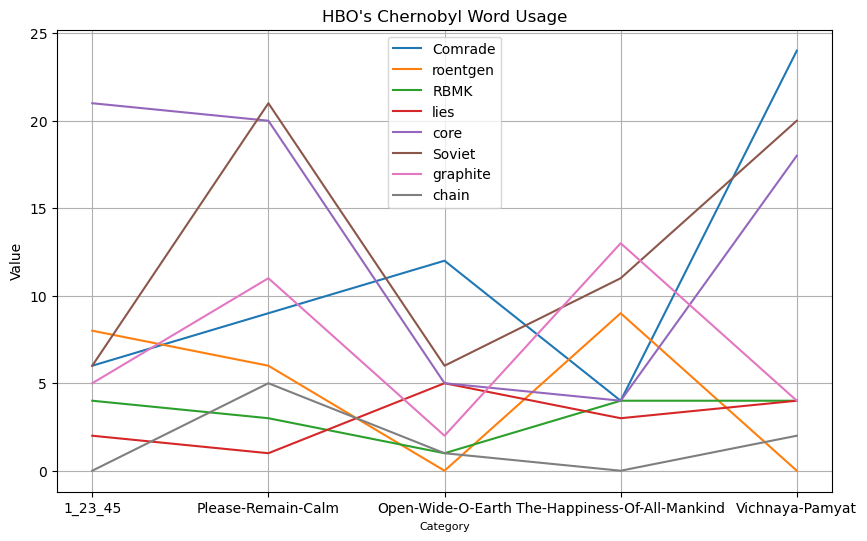

In [13]:
# Create a larger figure
plt.figure(figsize=(10, 6))

# Plot multiple line graphs
for index, row in Naive_Chernoby_DF.iterrows():
    plt.plot(Naive_Chernoby_DF.columns, row, label=f'{index}')

# Add labels and legend
plt.xlabel('Category', fontsize=8)
plt.ylabel('Value')
plt.title("HBO's Chernobyl Word Usage")
plt.legend()

# Add gridlines
plt.grid(True)

# Customize x-axis tick labels font size
plt.xticks(fontsize=10)

# Show the plot
plt.show()

A bit of extra analysis because why not. We see an uptick in the frequency of the words Comrade, Soviet, and Core in the final episode. If you haven't seen the show (your loss) I won't ruin it. But this is a Court Scene, in which Legasov (the protagonist), under oath, goes against what the Soviet part had wanted him to say, and instead tells the truth of what happened in Chernobyl. How the core of the RBMK reactor exploded, exposing the inner graphite due to the lies and negligence of the Soviet Communist Party. 

We also see how core's usage peaks in episode 1, this is where they initially fly into Chernobyl, and see the glowing sky above Reactor 4. They also see that the core has been exposed, which they inferred from the graphite strewn about the site. Graphite is only present within the core for you non-nuclear history buffs. 

A final note, in that the word 'lies' is never not used in any of the episodes. Quite telling don't you think?

## Boyer-Moore Algorithm 

The Boyer-Moore algorithm is a string search algorithm known for its efficiency in searching for occurrences of a pattern within a larger text. It works by scanning the text from left to right, comparing the pattern to substrings of the text. The algorithm utilizesthe bad character rule and the good suffix rule, to skip comparisons and achieve faster search times. We will implement the bad chracter rule here. 

The bad character rule involves scanning the text from right to left, and when a mismatch is encountered, it checks if the mismatched character in the text occurs in the pattern. If it doesn't, the pattern can be shifted by the length of the pattern; otherwise, it aligns the rightmost occurrence of the character in the pattern with the mismatched character in the text. 





In [14]:
def preprocess_bad_character(pattern):
    bad_character = {}
    for i, char in enumerate(pattern): #Here we iterate through every character of the input string
        bad_character[char] = i #Here we set the character's value to it's index. Note that if a character appears twice, the second time will
        #overwrite the first. This Character : Latest Index relationship is why we chose a dictionary to output
    return bad_character

In [15]:
example_bad_character = preprocess_bad_character('Conor_George_Sheehan')
example_bad_character #Example using yours truly 

{'C': 0,
 'o': 8,
 'n': 19,
 'r': 9,
 '_': 12,
 'G': 6,
 'e': 16,
 'g': 10,
 'S': 13,
 'h': 17,
 'a': 18}

In [16]:
def boyer_moore_search(text, pattern):
    indices = []
    n = len(text) # These values are important for how to algorithm searches through the corpus of text, stopping n-m before the final text character
    m = len(pattern)
    if m == 0:
        return indices
    bad_character = preprocess_bad_character(pattern)#processing the pattern we want to find
    i = 0 # This is where we begin iterating from, ground zero
    while i <= n - m:
        j = m - 1  #this euqals the final character of the pattern string, this is whats checked errytime initially
        while j >= 0 and pattern[j] == text[i + j]: # if this matches the text value, decrement j and check if the preceding character also matches
            j -= 1
        if j == -1:  # if j goes below 0, that means the entire string matched. Therefore we append the i value to indices, indicating the pattern is present
            indices.append(i)
            i += 1 # Move on a character in the text to be checked
        else:
            if text[i + j] in bad_character:  # If the value we are currently looking at in the text is not equal to the corresponding index in pattern, 
                #however it is present in the bad_character dictionary, we shift the pattern string along the text essentially and checking for a match again
                shift = max(1, j - bad_character[text[i + j]]) # This is the bad_character rule in action. If we mismatched character is present, we want to 
                #shift the pattern by j - (index of bad character) to ensure they allign. This is why  this algorithm is more optimal than the Naive approach
            #which always skips by 1
            else:
                shift = j + 1 # If we don't have anything in the dictionary, shift by the length of the pattern
            i += shift
    return indices

In [17]:
text = "Lorem ipsum dolor sit amet, consectetur adipiscing elit."
pattern = "sit"
    
occurrences = boyer_moore_search(text, pattern)
if occurrences:
    print("Pattern found at indices:", occurrences)
else:
    print("Pattern not found in the text.")

Pattern found at indices: [18]


Now let's check how long Boyer-Moore takes in comparison to the Naive method. 

In [18]:
BoyerMoore_Chernoby_DF = pd.DataFrame() # Calling the Dataframe Constructor. One of the weirder DF names might I add

for episode,episode__name in zip(text_list,episode_name): #iterating through the episode text file, and episode name simultaneously
    start_time = time.time()
    word_count = []
    for word in Chernobyl_phrases: #For each episode check each word
        occurrences = boyer_moore_search(episode, word) # Implement the Boyer Moore algorithm
        print(f'The word {word} appears in {episode__name} a total of {len(occurrences)} times') #Print our results to be sure the make sense
        word_count.append(len(occurrences))
    BoyerMoore_Chernoby_DF[episode__name[19:]] = word_count
    print('')
    end_time = time.time()
BoyerMoore_Chernoby_DF.index = Chernobyl_phrases
print(f'The total elapsed time for the Naive Algorithm is {round((end_time - start_time)*1000, 2)} ms') #Printing out our total time taken

The word Comrade appears in Chernobyl_Episode-11_23_45 a total of 6 times
The word roentgen appears in Chernobyl_Episode-11_23_45 a total of 8 times
The word RBMK appears in Chernobyl_Episode-11_23_45 a total of 4 times
The word lies appears in Chernobyl_Episode-11_23_45 a total of 2 times
The word core appears in Chernobyl_Episode-11_23_45 a total of 21 times
The word Soviet appears in Chernobyl_Episode-11_23_45 a total of 6 times
The word graphite appears in Chernobyl_Episode-11_23_45 a total of 5 times
The word chain appears in Chernobyl_Episode-11_23_45 a total of 0 times

The word Comrade appears in Chernobyl_Episode-2Please-Remain-Calm a total of 9 times
The word roentgen appears in Chernobyl_Episode-2Please-Remain-Calm a total of 6 times
The word RBMK appears in Chernobyl_Episode-2Please-Remain-Calm a total of 3 times
The word lies appears in Chernobyl_Episode-2Please-Remain-Calm a total of 1 times
The word core appears in Chernobyl_Episode-2Please-Remain-Calm a total of 20 time

In [19]:
BoyerMoore_Chernoby_DF

,1_23_45,Please-Remain-Calm,Open-Wide-O-Earth,The-Happiness-Of-All-Mankind,Vichnaya-Pamyat
Comrade,6,9,12,4,24
roentgen,8,6,0,9,0
RBMK,4,3,1,4,4
lies,2,1,5,3,4
core,21,20,5,4,18
Soviet,6,21,6,11,20
graphite,5,11,2,13,4
chain,0,5,1,0,2


We effectively halved the runtime here, going from ~150 ms in the Naive approach to ~75 ms here. Wowzers. 

The runtime complexity here depends on a few factors, the main one being if the pattern actually exists within the text. If it does not, imagine the pattern will shift *len(pattern)* each time. Therefore for a text/corpus of length n we'd have a runtime complexity of $O(n/len(pattern))$. 

Imagine a text that read *AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA*, which we were searching through for a pattern *XYZA*. That final character would match every time, but nothing else. The entire pattern would still be checked in the bad _character mismatch table. This would lead to a runtime complexity of $O(m*n)$

## KMP Algorithm

The Knuth-Morris-Pratt (KMP) algorithm efficiently searches for occurrences of a pattern within a text by utilizing a partial match table. This table is preprocessed from the pattern to determine the longest proper prefix of each prefix that is also a suffix. 

During the search process, the algorithm compares characters of the text with characters of the pattern from left to right. When a mismatch occurs, the algorithm utilizes the partial match table to determine how many characters can be safely skipped in the pattern without missing a potential match in the text. This is similar to the Boyer Moore algorithm using the bad_character table to see how many string characters could be skipped. 

By avoiding unnecessary comparisons and backtracking, the KMP algorithm achieves improved efficiency in string searching, making it highly suitable for large texts and patterns.

In [20]:
def compute_partial_match_table(pattern):
    table = [0] * len(pattern) # initialising a 1D array of 0s
    i, j = 0, 1 # 
    while j < len(pattern): 
        if pattern[i] == pattern[j]: # if both elements are equivalent, assign table value of j equal to i and increment both counters
            i += 1
            table[j] = i
            j += 1
        else:
            if i != 0: #if i is non-zero reassign its value to the previous tables value
                i = table[i - 1]
            else:
                table[j] = 0 #final worst case, if i is 0 and i != j, increment j only after setting it's partial match table value to 0
                j += 1
      #  print(table)
    return table


In [21]:
compute_partial_match_table('ababd')

[0, 0, 1, 2, 0]

In [27]:
def kmp_search(text, pattern):
    indices = []
    if not pattern:
        return indices # if the pattern is empty return an empty list
    partial_match_table = compute_partial_match_table(pattern) # create the failure function for this pattern
    i, j = 0, 0 # two pointers, one to monitor the text, one to monitor the pattern
    while i < len(text): # increment i through the text
        if text[i] == pattern[j]:
            i += 1
            j += 1
            if j == len(pattern): # if the first element of pattern matches element i in table, increment. If j = len(pattern) you've a match, add the
                indices.append(i - j)# initial index 
                j = partial_match_table[j - 1] # set j to the final value in the partial match table
        else:
            if j != 0: # if j has not been reset to 0, set it to its corresponding failure function value. Then repeat the text[i] = pattern[j] check
                j = partial_match_table[j - 1]
            else:
                i += 1 # if all else fails increment i 
    return indices

In [28]:
text = "ABABABABCABABABABABABABABABABABCABAB"
pattern = "ABAB"
occurrences = kmp_search(text, pattern)
if occurrences:
    print("Pattern found at indices:", occurrences)
else:
    print("Pattern not found in the text.")

Pattern found at indices: [0, 2, 4, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 32]


In [30]:
KMP_Chernoby_DF = pd.DataFrame() # Calling the Dataframe Constructor. One of the weirder DF names might I add

for episode,episode__name in zip(text_list,episode_name): #iterating through the episode text file, and episode name simultaneously
    start_time = time.time()
    word_count = []
    for word in Chernobyl_phrases: #For each episode check each word
        occurrences = kmp_search(episode, word) # Implement the Boyer Moore algorithm
        #print(f'The word {word} appears in {episode__name} a total of {len(occurrences)} times') #Print our results to be sure the make sense
        word_count.append(len(occurrences))
    KMP_Chernoby_DF[episode__name[19:]] = word_count
    end_time = time.time()
KMP_Chernoby_DF.index = Chernobyl_phrases
print(f'The total elapsed time for the Naive Algorithm is {round((end_time - start_time)*1000, 2)} ms') #Printing out our total time taken

The total elapsed time for the Naive Algorithm is 170.47 ms


This one acc took a bit longer than the Naive method. This makes sense, as the words we're actually looking for don't have any prefixes in them to match suffixes. Therefore their failure function is going to be just lists of 0 values. Resulting in basically a Naive search anyway. See below:

In [31]:
for word in Chernobyl_phrases:
    print(compute_partial_match_table(word))

[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]


Not great, not terrible.

# Dynamic Programming 

Dynamic programming is a problem-solving technique that efficiently solves complex problems by breaking them down into simpler subproblems. It relies on two key principles: optimal substructure and overlapping subproblems.

Optimal substructure means that the optimal solution to the overall problem can be constructed from the optimal solutions of its subproblems. 

Overlapping subproblems occur when the same subproblems are encountered multiple times during the computation. Dynamic programming addresses this by storing and reusing solutions to subproblems, either through memoization or tabulation. 

Memoization involves storing the results of function calls and retrieving them when the same inputs occur again. 
Solutions to subproblems are recursively computed and stored in a table or cache 
Memoization is suited for problems with overlapping subproblems and is used in a top-down approac

Tabulation involves solving subproblems iteratively and storing the results in a table, usually in a bottom-up manner. 
Unlike memoization, it doesn't require recursive function calls and starts with the simplest subproblems
h.

This approach is particularly useful for problems with overlapping subproblems, such as the Knapsack problem and longest common subsequence problems. Overall, dynamic programming enables significant performance improvements by efficiently solving subproblems and avoiding redundant computations.

## Knapsack Problem 

The Knapsack problem is a classic optimization problem in computer science and combinatorial optimization. It derives its name from the scenario of a burglar who must fill a knapsack with the most valuable items without exceeding its weight capacity.

The problem statement involves a set of items, each with a weight and a value. The goal is to determine the subset of items to include in the knapsack that maximizes the total value, while ensuring that the total weight does not exceed a given capacityts.

Due to its practical relevance and computational complexity, the Knapsack problem has been extensively studied and has applications in various fields, including resource allocation, finance, and logistics. It serves as a fundamental problem in algorithm design and optimization.

So we're going to solve the Knapsack problem initially through a brute force approach, and subsequently using a Dynamic Programming approach. We'll check the computation time difference between the two then. 

So, our problem is: We've broken into McDonalds. We're hungry after a night out, and we thought who better to get food from than a corporate conglomerate. However, we're also training for an Ironman so we need to maximise our calorie intake for fuel (Profit). The caveat here is we're after losing our belt on the dancefloor, so we can only take a  certain amount of weight before our pants fall off making our getaway nigh on impossible (weight limitation). We'll say our weight limit is 8kg. The pants are a good fit, but not built for Grand Theft Eurosaver. 

In [51]:
pants_weight_bearing_capacity = 12
calorie_vals = [300,600,1500,1800,2100,2500,3000]
weight_vals = [2,3,4,5,6,8,9]
eurosaver_dict = {
1: 'McNuggets (6 Pack)',
2: 'McFlurry + McNuggets combo',
3: 'Happy Meal with some Cheesy Fries',
4: 'Trible Double Quarter Pounder Burger',
5: 'Two Half pounders stuck together with some sellotape',
6: 'A deep fried pair of wellies with a Diet Coke',
7: 'Ronald McDonald himself'
}

In [58]:
import timeit
def knapsack_brute_force(values, weights, capacity):
    start_time = timeit.default_timer() # initialising our start time, number of calculations
    n = len(values)
    max_value = 0 # and the maximum # of calories we can  get without our pants falling off
    selected_items = []

    # Generate all possible subsets of items
    for i in range(2**n): #Here we iterate from 0 to 2^[n} - 1
        total_weight = 0
        total_value = 0 #these values are reinitialised for every permutation
        subset = []

        for j in range(n):
            if (i >> j) & 1: # in this inner loop, we do a bit-by-bit analysis of the i value. We shift i's bits right by 1, and then check if the 
                #final bit is equal to 1. if so we add total weight/value. Note this is done for j = 0,1,2,..n. So end up shifting i by its entireity 
                #by the end of the loop
                total_weight += weights[j]
                total_value += values[j]
                subset.append(j)

        # Check if the subset is feasible and update the maximum value
        if total_weight <= capacity and total_value > max_value:
            max_value = total_value #Here we constantly check if we've gotten a max combination, and reassign it if it exceeds the last max value
            selected_items = subset.copy()
            max_weight = total_weight
    
    end_time = timeit.default_timer()
    duration  = round((end_time - start_time),5)*1e6
    print(f'Duration is {duration}', 'ms')
    items = [eurosaver_dict[item] for item in selected_items]
    return max_value, items, max_weight

In [59]:
max_value, selected_items, total_weight = knapsack_brute_force(calorie_vals, weight_vals, pants_weight_bearing_capacity)
print("Maximum Calorie Intake (brute force):", max_value)
print("Selected items (brute force):", selected_items)
print("Weight (brute force):", total_weight, 'kg')

Duration is 330.0 ms
Maximum Calorie Intake (brute force): 4000
Selected items (brute force): ['McFlurry + McNuggets combo', 'Two Half pounders stuck together with some sellotape']
Weight (brute force): 12 kg


Woah guys, we got some nice food, and our pants are safe. It took us 330ms. That's awesome. I just want to show the bitwise analysis of the inner loop in each iteration more specifically.

In [64]:
# Define a function to convert a number to its binary representation
def to_binary(number):
    binary = '{:04b}'.format(number) 
    return binary

# Generate all possible subsets of items
for i in range(2**4): #Here we iterate from 0 to 2^[n} - 1
    print('The number is: ', i, ' which has a binary representation of: ', to_binary(i)) 
    for j in range(4):
        print('For a j of: ', j, "i's representation is now", ((i>>j) & 1))

The number is:  0  which has a binary representation of:  0000
For a j of:  0 i's representation is now 0
For a j of:  1 i's representation is now 0
For a j of:  2 i's representation is now 0
For a j of:  3 i's representation is now 0
The number is:  1  which has a binary representation of:  0001
For a j of:  0 i's representation is now 1
For a j of:  1 i's representation is now 0
For a j of:  2 i's representation is now 0
For a j of:  3 i's representation is now 0
The number is:  2  which has a binary representation of:  0010
For a j of:  0 i's representation is now 0
For a j of:  1 i's representation is now 1
For a j of:  2 i's representation is now 0
For a j of:  3 i's representation is now 0
The number is:  3  which has a binary representation of:  0011
For a j of:  0 i's representation is now 1
For a j of:  1 i's representation is now 1
For a j of:  2 i's representation is now 0
For a j of:  3 i's representation is now 0
The number is:  4  which has a binary representation of:  01

See how in the above, we had 16 possible combinations. This 16 was arbitrary, just imagine we had an array of length 4 therefore $2^{4} = 16$. These values 0 to 15, are then converted to 4 byte binary. Depending on what element in that representation is 1, we then chose those elements from the weights and costs in the original loop. This method is clever in the sense that by switching to 4 byte binary we represent every possible combination of a binary 4 digit array. However it is not clever in the sense that we're not using Dynamic Programming. 

This method has a runtime complxity of $O(2^{n} * n)$. This is quite bad, and is due to the fact that for the $2^{n}$ combinations, we must check the weight/profit summations of n values. 

Enough babbling. Let's get to the Knapsack Method.

### Dynamic Approach

In [74]:
def knapsack_01(values, weights, capacity):
    start_time = timeit.default_timer()
    n = len(values)
    # Initialize a table of all 0's to store the maximum value for different combinations of items and capacities
    dp = [[0] * (capacity + 1) for _ in range(n + 1)]
    #This table is a grid of items versus max weight at each possible weight value up to the capacity. It's easier to visualise in the printed tables
    for i in dp:
        print(i)
    # Build the table iteratively, moving down through each row, and subsequently through each column using a nested loop
    for i in range(1, n + 1):
        print('')
        for w in range(1, capacity + 1):# for a given row, iterate through the columns
            if weights[i - 1] <= w:
                # If the current weight column index exceeds the corresponding rows weight value, we assign the max value from the below to the table
                # This is the max of the previous rows column value, the profit corresponding to that row plus a table value (which Im not sure of the significance of?) 
                dp[i][w] = max(dp[i - 1][w], values[i - 1] + dp[i - 1][w - weights[i - 1]])
            else:
                # If the current item cannot be included, use the value from the previous row
                dp[i][w] = dp[i - 1][w]
        for i in dp:
            print(i)
    # Trace back through the table to find the selected items
    selected_items = []
    i, w = n, capacity # setting these values = table dimensions so we start at bottom right (largest value)
    while i > 0 and w > 0:
        if dp[i][w] != dp[i - 1][w]: #If these columns val is different to the preceding row val for that column, we know something has been added
            selected_items.append(i - 1) # which can only be the weight associated to the row. We use i - 1 as we added a row of 0's to the table initially
            w -= weights[i - 1]
        i -= 1 # go back a row and itereate the same check 

    end_time = timeit.default_timer()
    duration  = round((end_time - start_time),5)*1e6
    print(f'Duration is {duration}', 'ms')
    # Return the maximum value and the indices of the selected items
    return dp[n][capacity], selected_items


In [75]:
Profit = [1,2,5,6]
Weight = [2,3,4,5]
Max = 8
knapsack_01(Profit,Weight,Max)

[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]

[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]

[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 1, 2, 2, 3, 3, 3, 3]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]

[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 1, 2, 2, 3, 3, 3, 3]
[0, 0, 1, 2, 5, 5, 6, 7, 7]
[0, 0, 0, 0, 0, 0, 0, 0, 0]

[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 1, 2, 2, 3, 3, 3, 3]
[0, 0, 1, 2, 5, 5, 6, 7, 7]
[0, 0, 1, 2, 5, 6, 6, 7, 8]
Duration is 460.0 ms


(8, [3, 1])

This implementation provided is an example of tabulation in dynamic programming. Tabulation involves solving subproblems iteratively and storing the results in a table, typically in a bottom-up manner.

In this implementation:

1. We initialize a table (`dp`) to store the maximum value for different combinations of items and capacities.
2. We iteratively fill in the table, considering each item and capacity combination.
3. We use the values computed in previous iterations to compute the values for larger subproblems.
4. Finally, we use the filled table to find the solution to the original problem.

This approach avoids recursion and directly computes the solutions to all subproblems in a systematic manner, making it an example of tabulation in dynamic programming.

The runtime complexity of the dynamic tabulation approach for the 0/1 Knapsack problem is $O(n.W)$, where $n$ is the number of items and $W$ is the capacity of the knapsack.

Here's why:

- We initialize a table $(dp)$ of size $n+1 \times W+1$, where $n$ is the number of items and $W$ is the capacity of the knapsack. This takes $O(n.W)$ time and space.
- We then fill in each cell of the table once, considering each item and each possible capacity. This requires iterating over all $n$ items and all $W$ capacities. Therefore, the time complexity of filling in the table is $O(n.W)$.
- Finally, we trace back through the table to find the selected items. This step takes $O(n + W)$ time, as we iterate over $n$ items and a capacity that can range from 0 to $W$.

Overall, the dynamic tabulation approach for the 0/1 Knapsack problem has a runtime complexity of $O(n.W)$. It is efficient for moderate-sized problem instances, but it can become impractical for very large values of $n$ and $W$.

Let's check our McDonald's Thief and see how quick this method is compared to the brute force method. 

In [77]:
max_value, selected_items= knapsack_01(calorie_vals, weight_vals, pants_weight_bearing_capacity)
print("Maximum Calorie Intake (brute force):", max_value)
print("Selected items (brute force):", selected_items)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300]
[0, 0, 300, 600, 600, 900, 900, 900, 900, 900, 900, 900, 900]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0,

We got the same items alright, but took a bit longer, lets check how long it takes without printing the matrixes out 

In [80]:
def knapsack_02(values, weights, capacity):
    start_time = timeit.default_timer()
    n = len(values)
    # Initialize a table of all 0's to store the maximum value for different combinations of items and capacities
    dp = [[0] * (capacity + 1) for _ in range(n + 1)]
    # Build the table iteratively, moving down through each row, and subsequently through each column using a nested loop
    for i in range(1, n + 1):
        for w in range(1, capacity + 1):# for a given row, iterate through the columns
            if weights[i - 1] <= w:
                # If the current weight column index exceeds the corresponding rows weight value, we assign the max value from the below to the table
                # This is the max of the previous rows column value, the profit corresponding to that row plus a table value (which Im not sure of the significance of?) 
                dp[i][w] = max(dp[i - 1][w], values[i - 1] + dp[i - 1][w - weights[i - 1]])
            else:
                # If the current item cannot be included, use the value from the previous row
                dp[i][w] = dp[i - 1][w]
    # Trace back through the table to find the selected items
    selected_items = []
    i, w = n, capacity # setting these values = table dimensions so we start at bottom right (largest value)
    while i > 0 and w > 0:
        if dp[i][w] != dp[i - 1][w]: #If these columns val is different to the preceding row val for that column, we know something has been added
            selected_items.append(i - 1) # which can only be the weight associated to the row. We use i - 1 as we added a row of 0's to the table initially
            w -= weights[i - 1]
        i -= 1 # go back a row and itereate the same check 

    end_time = timeit.default_timer()
    duration  = round((end_time - start_time),5)*1e6
    print(f'Duration is {duration}', 'ms')
    # Return the maximum value and the indices of the selected items
    return dp[n][capacity], selected_items

max_value, selected_items= knapsack_02(calorie_vals, weight_vals, pants_weight_bearing_capacity)
print("Maximum Calorie Intake (Dynamic Programming):", max_value)
print("Selected items (Dynamic Programming):", selected_items)

Duration is 100.0 ms
Maximum Calorie Intake (Dynamic Programming): 4000
Selected items (Dynamic Programming): [5, 2]


Holy smokes, look at that, it's about 30 microseconds quicker for this small amount of data. Smashing stuff. Printing takes its toll apparently. 

## Longest Common Subsequence

The Longest Common Subsequence (LCS) problem is a classic problem in computer science, specifically in the field of dynamic programming. It involves finding the longest subsequence that is common to two given sequences (strings, arrays, etc.). A subsequence is a sequence that can be derived from another sequence by deleting some or no elements without changing the order of the remaining elements.

I found the following video to be a great help in explaining the problem: https://www.youtube.com/watch?v=sSno9rV8Rhg

Here's a brief explanation of the problem:

- Given two sequences $X$ and $Y$, the goal is to find the length of the longest subsequence that is common to both sequences.
- The subsequence does not necessarily have to be contiguous in the original sequences.
- For example, given sequences $X = ABCBDAB $ and $Y = BDCAB$, the longest common subsequence is $BCAB$ with a length of 4.

To solve the LCS problem, dynamic programming is often employed. The problem can be broken down into smaller subproblems, and the solutions to these subproblems can be used to construct the solution to the original problem. The dynamic programming approach typically involves constructing a table to store the lengths of the longest common subsequences for different prefixes of the input sequences. This table is typically of dimensions $m \times n$ where m and n are the string lengths of the strings in question. 

Once the table is filled, the length of the LCS can be found in the bottom-right corner of the table. Additionally, the LCS itself can be reconstructed by tracing back through the table from the bottom-right corner.

In [100]:
def longest_common_subsequence(X, Y): 
    m = len(X)
    n = len(Y)

    # Initialize a table to store the lengths of longest common subsequences
    dp = [[0] * (n + 1) for _ in range(m + 1)] # Defining the grid to be (m+1) times (n+1) for a row and column of 0's
    for row in dp:
        print(row)
    print(' ')
    # Fill the table row by row, starting at row m + 1 and column n + 1
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if X[i - 1] == Y[j - 1]: # If the corresponding string values match, set the value in grid = left upper diagonal + 1
                dp[i][j] = dp[i - 1][j - 1] + 1
            else:
                dp[i][j] = max(dp[i - 1][j], dp[i][j - 1]) # If there isn't any match, set it to the max of the preceding row or column value above
        for row in dp:
            print(row)
        print(' ')
    
    # Reconstruct the longest common subsequence, starting from the bottom right table value
    lcs_length = dp[m][n]
    lcs = []
    i, j = m, n
    while i > 0 and j > 0:
        if X[i - 1] == Y[j - 1]:
            lcs.append(X[i - 1]) # This is the reverse of the first condition within the inner loop
            i -= 1 # Note that we only append at the base of a diagonal line, if you trace back the matrices below on pen and paper!
            j -= 1
        elif dp[i - 1][j] > dp[i][j - 1]:
            i -= 1
        else:
            j -= 1

    # Reverse the LCS to get the correct order, because we started at the final string character
    lcs.reverse()

    return lcs_length, ''.join(lcs)

In [101]:
# Example usage:
X = "ABCBDAB"
Y = "BDCAB"
length, lcs = longest_common_subsequence(X, Y)
print("Length of Longest Common Subsequence:", length)
print("Longest Common Subsequence:", lcs)

[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
 
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 1]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
 
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 1]
[0, 1, 1, 1, 1, 2]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
 
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 1]
[0, 1, 1, 1, 1, 2]
[0, 1, 1, 2, 2, 2]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
 
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 1]
[0, 1, 1, 1, 1, 2]
[0, 1, 1, 2, 2, 2]
[0, 1, 1, 2, 2, 3]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
 
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 1]
[0, 1, 1, 1, 1, 2]
[0, 1, 1, 2, 2, 2]
[0, 1, 1, 2, 2, 3]
[0, 1, 2, 2, 2, 3]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
 
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 1]
[0, 1, 1, 1, 1, 2]
[0, 1, 1, 2, 2, 2]


# Multithreading to Multiply Matrices

Multithreading is a programming technique that enables multiple threads of execution to run concurrently within a single process. Each thread represents an independent flow of control capable of executing instructions independently. Multithreading improves performance and responsiveness by allowing tasks to be executed simultaneously on multiple CPU cores or logical processors. On my own laptop, I have 8 cores, with 16 Logical Processors. Multithreading in theory should allow my to execute 16 threads simultaneously. What is the difference between a CPU core and a Logical Processor I hear you hear me think. 

**CPU Cores:** A CPU core is a physical processing unit capable of executing instructions. Modern CPUs often have multiple cores, allowing them to execute multiple tasks simultaneously. Each core can execute instructions independently and in parallel with other cores.

**Logical Processors:** A logical processor, also known as a hardware thread or a logical core, represents a virtual processing unit within a physical CPU core. Many modern CPUs use a technology called simultaneous multithreading (SMT), which allows a single physical core to act as multiple logical processors. Each logical processor can execute its own thread of instructions concurrently with other logical processors on the same core.

**Thread:** A thread is a basic unit of execution within a process, representing a separate sequence of instructions that can run concurrently with other threads. Threads share the same memory space and resources within a process, allowing them to communicate and coordinate with each other. Threads are lightweight and efficient, making them useful for multitasking and parallel processing in software applications.

Multithreading so essentially means executing these threads concurrently on seperate logical processors, in order to improve performance. How on earth could this improve performance I wonder?

Multithreading so essentially means executing these threads concurrently on seperate logical processors, in order to improve performance. How on earth could this improve performance I wonder?

Multithreading is a programming technique that enables concurrent execution of multiple threads within the same process, enhancing performance and responsiveness by allowing tasks to run simultaneously. 

It leverages modern multi-core processors for efficient resource utilization, ensuring faster execution of tasks. By offloading heavy computations to separate threads, user interfaces remain smooth and interactive, even during background operations.

Multithreading facilitates parallel execution of independent tasks, optimizing resource usage and speeding up overall processing, particularly in applications with parallelizable workloads like scientific simulations.

So, can we use multithreading to our advantage, perhaps for matrix multiplication of some kind, and how would this work?

So we know for a matrix $A_{n,m}$, and a matrix $B_{m,k}$ the matrix product $C$, will be of size $C_{n,k}$, with each element $c \in C$ being calculated by the following: $c_{i,j} = \sum_{z = 1}^{n} a_{i}.b_{j}$. So essentially element $(0,0)$ within $C$ is calculated by obtaining the dot product of the row vector $a_{0}$ from $A$ and the column vector $b_{0}$ from $B$, and so on and so forth. 

However the thing is, all of these matrix elements $c_{i,j} \in C$ can be calculated independant of one another, they only depend on the elements of $A$ and $B$, nothing to do with other elements of $C$. So, why don't we use a few of our logical processors to simultaneously calculate certain regions of the resultant matrix? We can see the time taken in comparison to a non-multithreaded example then and see what all the fuss is about!

In [108]:
# Define a function to compute a portion of the resulting matrix
def compute_partial_result(A, B, result, start_row, end_row):
    for i in range(start_row, end_row):
        for j in range(B.shape[1]):
            result[i][j] = np.dot(A[i], B[:, j])

# Define the matrices
A = np.random.randint(1, 10, size=(100, 100))
B = np.random.randint(1, 10, size=(100, 100))
result = np.zeros((A.shape[0], B.shape[1]))

# Split the computation into multiple threads
num_threads = 4
threads = []
rows_per_thread = A.shape[0] // num_threads # Each Logical Processor will calculate a quarter of the resultant Matrixes rows

for i in range(num_threads):
    start_time = time.time()
    start_row = i * rows_per_thread # (0,1,2,3) * 25
    end_row = (i + 1) * rows_per_thread if i < num_threads - 1 else A.shape[0] # (0,1,2) * 75 unless i = 3. Then set end_row as end of Matrix A
    thread = threading.Thread(target=compute_partial_result, args=(A, B, result, start_row, end_row)) # Assign the partial result function & arguments to a thread
    threads.append(thread) # append each thread object to a list
    thread.start() #starts each thread

# Wait for all threads to complete
for thread in threads:
    thread.join() # for each thread object created to finish execution
    end_time = time.time()

# Display the result
print(result)
print(f'Total time taken is {round((end_time - start_time),4)} s')

[[2399. 2398. 2666. ... 2644. 2439. 2665.]
 [2362. 2377. 2572. ... 2648. 2471. 2725.]
 [2221. 2233. 2584. ... 2335. 2269. 2359.]
 ...
 [2333. 2364. 2602. ... 2572. 2325. 2713.]
 [2227. 2234. 2565. ... 2479. 2331. 2494.]
 [2221. 2232. 2448. ... 2355. 2342. 2432.]]
Total time taken is 0.1111 s


In [112]:
# Perform matrix multiplication
start_time = time.time()
result = np.dot(A, B)
end_time = time.time()

# Print the result
print("Result of matrix multiplication:")
print(result)
print(f'Total time taken is {round((end_time - start_time),4)} s')

Result of matrix multiplication:
[[2399 2398 2666 ... 2644 2439 2665]
 [2362 2377 2572 ... 2648 2471 2725]
 [2221 2233 2584 ... 2335 2269 2359]
 ...
 [2333 2364 2602 ... 2572 2325 2713]
 [2227 2234 2565 ... 2479 2331 2494]
 [2221 2232 2448 ... 2355 2342 2432]]
Total time taken is 0.0053 s


OK, so using a single logical processor was quicker in this case, but this is a rather simple example. The benefits of multithreading are most likely lost on this example. 